# Lab 2: Neural Architecture Search
ELEC70109/EE9-AML3-10/EE9-AO25


## Task 1 - IntegerLinear with different widths

## 1.a 
We modify the `construct_model` function to include the `LinearInteger`, and add the `width` and `frac_width` parameters to the `search_space` dictionary. 

```python

search_space = {
    "linear_layer_choices": [
        torch.nn.Linear,
        LinearInteger,

    ],
    "width_choices": [8, 16, 32],
    "frac_width_choices": [2, 4, 8],
}


def construct_model(trial):

    # Fetch the model
    trial_model = deepcopy(base_model)

    # Quantize layers according to optuna suggestions
    for name, layer in trial_model.named_modules():
        if isinstance(layer, torch.nn.Linear):
            new_layer_cls = trial.suggest_categorical(
                f"{name}_type",
                search_space["linear_layer_choices"],
            )

            if new_layer_cls == torch.nn.Linear:
                continue

            kwargs = {
                "in_features": layer.in_features,
                "out_features": layer.out_features,
            }

            # If the chosen layer is integer, define the low precision config
            if new_layer_cls == LinearInteger:
                width = trial.suggest_categorical(
                    "width",
                    search_space["width_choices"],
                )
                frac_width = trial.suggest_categorical(
                    "frac_width",
                    search_space["frac_width_choices"],
                )
                kwargs["config"] = {
                    "data_in_width":width,
                    "data_in_frac_width": frac_width,
                    "weight_width":width, 
                    "weight_frac_width": frac_width,
                    "bias_width": width,
                    "bias_frac_width": frac_width,
                }
            # elif... (other precisions)

            # Create the new layer (copy the weights)
            new_layer = new_layer_cls(**kwargs)
            new_layer.weight.data = layer.weight.data

            # Replace the layer in the model
            deepsetattr(trial_model, name, new_layer)
```

## 1.b

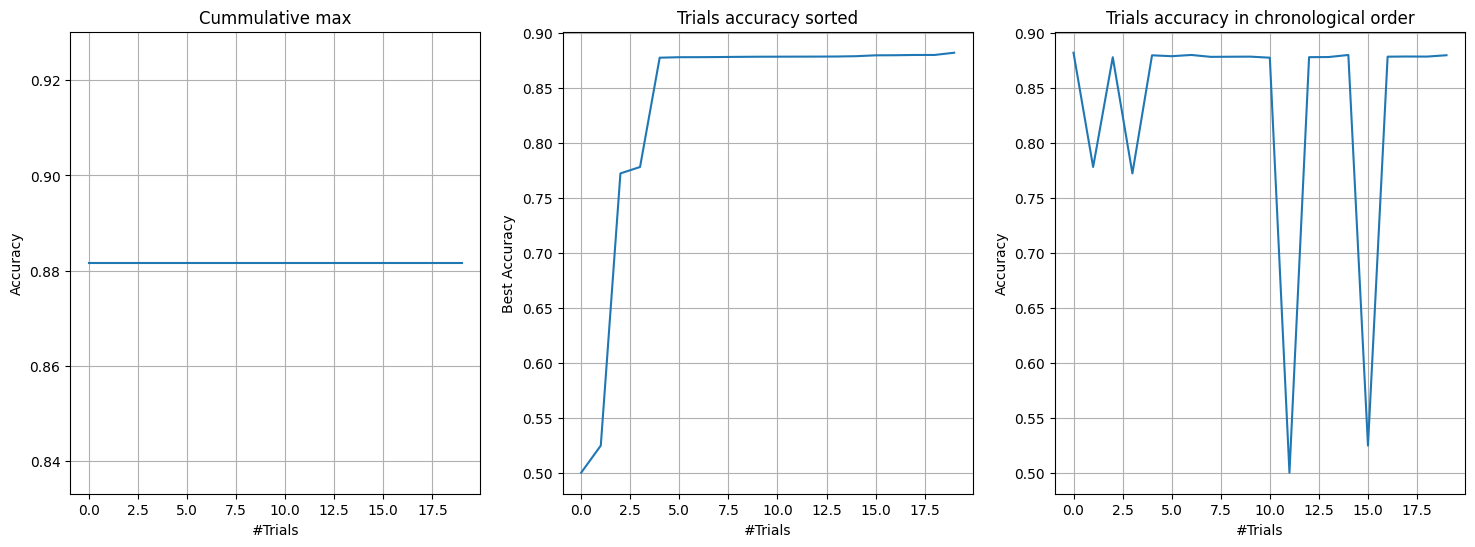

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

study_linear = pd.read_csv("results_3_1.csv")
trials = study_linear.number
values_linear = study_linear.value
sorted_values_linear = values_linear.sort_values()
max_values_linear = values_linear.cummax()


fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# Plot without sorted values
ax[1].plot(trials, sorted_values_linear)
ax[1].set_xlabel("#Trials")
ax[1].set_ylabel("Best Accuracy")
ax[1].grid()
ax[1].set_title("Trials accuracy sorted")

# Plot with sorted values
ax[0].plot(
    trials,
    max_values_linear,
)
ax[0].set_xlabel("#Trials")
ax[0].set_ylabel("Accuracy")
ax[0].grid()
ax[0].set_title("Cummulative max")

# Plot all the accuracy values in order
ax[2].plot(trials, values_linear)
ax[2].set_xlabel("#Trials")
ax[2].set_ylabel("Accuracy")
ax[2].grid()
ax[2].set_title("Trials accuracy in chronological order")

plt.show()

We were lucky this time, as it seems that the sampler has found the best configuration during the first trial.

In [3]:
from utils import get_trial_config

config = get_trial_config(study_linear, 5)
config

{'params_bert.encoder.layer.0.attention.self.key_type': "<class 'chop.nn.quantized.modules.linear.LinearInteger'>",
 'params_bert.encoder.layer.0.intermediate.dense_type': "<class 'chop.nn.quantized.modules.linear.LinearInteger'>",
 'params_bert.encoder.layer.0.output.dense_type': "<class 'torch.nn.modules.linear.Linear'>",
 'params_bert.encoder.layer.1.attention.output.dense_type': "<class 'torch.nn.modules.linear.Linear'>",
 'params_bert.encoder.layer.1.attention.self.key_type': "<class 'chop.nn.quantized.modules.linear.LinearInteger'>",
 'params_bert.encoder.layer.1.intermediate.dense_type': "<class 'torch.nn.modules.linear.Linear'>",
 'params_bert.encoder.layer.1.output.dense_type': "<class 'chop.nn.quantized.modules.linear.LinearInteger'>",
 'params_classifier_type': "<class 'torch.nn.modules.linear.Linear'>",
 'params_frac_width': 4,
 'params_width': 32}

# Task 2

## 2.a 

We modify the `construct_model` function to include more layer types.

```python

search_space = {
    "linear_layer_choices": [
        torch.nn.Linear,
        LinearInteger,
        LinearMinifloatDenorm,
        LinearMinifloatIEEE,
    ],
    "width_choices": [8, 16, 32],
    "frac_width_choices": [2, 4, 8],
}

def construct_model(trial):

    # Fetch the model
    trial_model = deepcopy(base_model)

    # Quantize layers according to optuna suggestions
    for name, layer in trial_model.named_modules():
        if isinstance(layer, torch.nn.Linear):
            new_layer_cls = trial.suggest_categorical(
                f"{name}_type",
                search_space["linear_layer_choices"],
            )

            if new_layer_cls == torch.nn.Linear:
                continue

            kwargs = {
                "in_features": layer.in_features,
                "out_features": layer.out_features,
            }

            # If the chosen layer is integer, define the low precision config
            if new_layer_cls == LinearInteger:
                width = trial.suggest_categorical(
                    "width",
                    search_space["width_choices"],
                )
                frac_width = trial.suggest_categorical(
                    "frac_width",
                    search_space["frac_width_choices"],
                )
                kwargs["config"] = {
                    "data_in_width": width,
                    "data_in_frac_width": frac_width,
                    "weight_width": width,
                    "weight_frac_width": frac_width,
                    "bias_width": width,
                    "bias_frac_width": frac_width,
                }
            elif new_layer_cls == LinearMinifloatDenorm:
                width = trial.suggest_categorical(
                    "width",
                    search_space["width_choices"],
                )
                exponent_width = trial.suggest_categorical(
                    "exponent_width",
                    search_space["frac_width_choices"],
                )
                exponent_bias = trial.suggest_categorical(
                    "exponent_bias",
                    search_space["frac_width_choices"],
                )
                kwargs["config"] = {
                    "data_in_width": width,
                    "data_in_exponent_width": exponent_width,
                    "data_in_exponent_bias": exponent_bias,
                    "weight_width": width,
                    "weight_exponent_width": exponent_width,
                    "weight_exponent_bias": exponent_bias,
                    "bias_width": width,
                    "bias_exponent_width": exponent_width,
                    "bias_exponent_bias": exponent_bias,
                }

            elif new_layer_cls == LinearMinifloatIEEE:
                width = trial.suggest_categorical(
                    "width",
                    search_space["width_choices"],
                )
                exponent_width = trial.suggest_categorical(
                    "exponent_width",
                    search_space["frac_width_choices"],
                )
                exponent_bias = trial.suggest_categorical(
                    "exponent_bias",
                    search_space["frac_width_choices"],
                )
                kwargs["config"] = {
                    "data_in_width": width,
                    "data_in_exponent_width": exponent_width,
                    "data_in_exponent_bias": exponent_bias,
                    "weight_width": width,
                    "weight_exponent_width": exponent_width,
                    "weight_exponent_bias": exponent_bias,
                    "bias_width": width,
                    "bias_exponent_width": exponent_width,
                    "bias_exponent_bias": exponent_bias,
                }

            # Create the new layer (copy the weights)
            new_layer = new_layer_cls(**kwargs)
            new_layer.weight.data = layer.weight.data

            # Replace the layer in the model
            deepsetattr(trial_model, name, new_layer)

    return trial_model
```

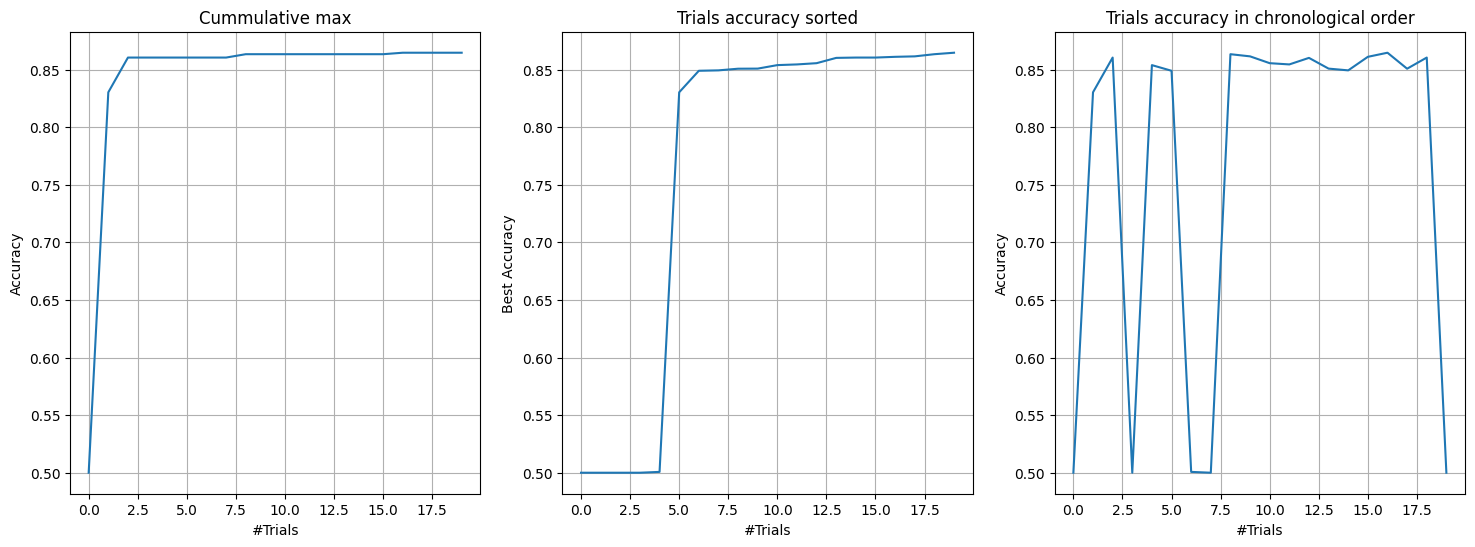

In [4]:
study_linear_2 = pd.read_csv("results_3_2.csv")
trials = study_linear_2.number
values_linear_2 = study_linear_2.value
sorted_values_linear_2 = values_linear_2.sort_values()
max_values_linear_2 = values_linear_2.cummax()


fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# Plot without sorted values
ax[1].plot(trials, sorted_values_linear_2)
ax[1].set_xlabel("#Trials")
ax[1].set_ylabel("Best Accuracy")
ax[1].grid()
ax[1].set_title("Trials accuracy sorted")

# Plot with sorted values
ax[0].plot(
    trials,
    max_values_linear_2,
)
ax[0].set_xlabel("#Trials")
ax[0].set_ylabel("Accuracy")
ax[0].grid()
ax[0].set_title("Cummulative max")

# Plot all the accuracy values in order
ax[2].plot(trials, values_linear_2)
ax[2].set_xlabel("#Trials")
ax[2].set_ylabel("Accuracy")
ax[2].grid()
ax[2].set_title("Trials accuracy in chronological order")

plt.show()

In [5]:
config = get_trial_config(study_linear_2, 5)
config

{'params_bert.encoder.layer.0.attention.self.key_type': "<class 'chop.nn.quantized.modules.linear.LinearMinifloatDenorm'>",
 'params_bert.encoder.layer.0.intermediate.dense_type': "<class 'chop.nn.quantized.modules.linear.LinearInteger'>",
 'params_bert.encoder.layer.0.output.dense_type': "<class 'chop.nn.quantized.modules.linear.LinearInteger'>",
 'params_bert.encoder.layer.1.attention.output.dense_type': "<class 'torch.nn.modules.linear.Linear'>",
 'params_bert.encoder.layer.1.attention.self.key_type': "<class 'chop.nn.quantized.modules.linear.LinearMinifloatDenorm'>",
 'params_bert.encoder.layer.1.intermediate.dense_type': "<class 'chop.nn.quantized.modules.linear.LinearInteger'>",
 'params_bert.encoder.layer.1.output.dense_type': "<class 'chop.nn.quantized.modules.linear.LinearMinifloatIEEE'>",
 'params_classifier_type': "<class 'chop.nn.quantized.modules.linear.LinearMinifloatIEEE'>",
 'params_exponent_bias': 2,
 'params_exponent_width': 4,
 'params_frac_width': 2.0,
 'params_widt

In [8]:
study_linear_2

,Unnamed: 0,number,value,datetime_start,datetime_complete,duration,params_bert.encoder.layer.0.attention.self.key_type,params_bert.encoder.layer.0.intermediate.dense_type,params_bert.encoder.layer.0.output.dense_type,params_bert.encoder.layer.1.attention.output.dense_type,params_bert.encoder.layer.1.attention.self.key_type,params_bert.encoder.layer.1.intermediate.dense_type,params_bert.encoder.layer.1.output.dense_type,params_classifier_type,params_exponent_bias,params_exponent_width,params_frac_width,params_width,user_attrs_model,state
0,0,0,0.50000,2025-02-05 15:26:26.794936,2025-02-05 15:27:53.496605,0 days 00:01:26.701669,<class 'torch.nn.modules.linear.Linear'>,<class 'torch.nn.modules.linear.Linear'>,<class 'torch.nn.modules.linear.Linear'>,<class 'chop.nn.quantized.modules.linear.Linea...,<class 'chop.nn.quantized.modules.linear.Linea...,<class 'chop.nn.quantized.modules.linear.Linea...,<class 'chop.nn.quantized.modules.linear.Linea...,<class 'chop.nn.quantized.modules.linear.Linea...,2,8,8.0,8,BertForSequenceClassification(\n (bert): Bert...,COMPLETE
1,1,1,0.83032,2025-02-05 15:27:53.505735,2025-02-05 15:31:18.124367,0 days 00:03:24.618632,<class 'chop.nn.quantized.modules.linear.Linea...,<class 'chop.nn.quantized.modules.linear.Linea...,<class 'chop.nn.quantized.modules.linear.Linea...,<class 'chop.nn.quantized.modules.linear.Linea...,<class 'chop.nn.quantized.modules.linear.Linea...,<class 'chop.nn.quantized.modules.linear.Linea...,<class 'chop.nn.quantized.modules.linear.Linea...,<class 'chop.nn.quantized.modules.linear.Linea...,2,4,2.0,32,BertForSequenceClassification(\n (bert): Bert...,COMPLETE
2,2,2,0.86048,2025-02-05 15:31:18.134654,2025-02-05 15:33:14.304350,0 days 00:01:56.169696,<class 'torch.nn.modules.linear.Linear'>,<class 'chop.nn.quantized.modules.linear.Linea...,<class 'chop.nn.quantized.modules.linear.Linea...,<class 'torch.nn.modules.linear.Linear'>,<class 'torch.nn.modules.linear.Linear'>,<class 'chop.nn.quantized.modules.linear.Linea...,<class 'chop.nn.quantized.modules.linear.Linea...,<class 'chop.nn.quantized.modules.linear.Linea...,4,8,8.0,16,BertForSequenceClassification(\n (bert): Bert...,COMPLETE
3,3,3,0.50000,2025-02-05 15:33:14.313581,2025-02-05 15:36:19.051162,0 days 00:03:04.737581,<class 'chop.nn.quantized.modules.linear.Linea...,<class 'chop.nn.quantized.modules.linear.Linea...,<class 'chop.nn.quantized.modules.linear.Linea...,<class 'chop.nn.quantized.modules.linear.Linea...,<class 'torch.nn.modules.linear.Linear'>,<class 'chop.nn.quantized.modules.linear.Linea...,<class 'chop.nn.quantized.modules.linear.Linea...,<class 'chop.nn.quantized.modules.linear.Linea...,2,8,2.0,16,BertForSequenceClassification(\n (bert): Bert...,COMPLETE
4,4,4,0.85392,2025-02-05 15:36:19.062141,2025-02-05 15:40:33.876515,0 days 00:04:14.814374,<class 'chop.nn.quantized.modules.linear.Linea...,<class 'chop.nn.quantized.modules.linear.Linea...,<class 'chop.nn.quantized.modules.linear.Linea...,<class 'chop.nn.quantized.modules.linear.Linea...,<class 'torch.nn.modules.linear.Linear'>,<class 'torch.nn.modules.linear.Linear'>,<class 'chop.nn.quantized.modules.linear.Linea...,<class 'chop.nn.quantized.modules.linear.Linea...,4,2,NaN,32,BertForSequenceClassification(\n (bert): Bert...,COMPLETE
5,5,5,0.84900,2025-02-05 15:40:33.888027,2025-02-05 15:44:06.813722,0 days 00:03:32.925695,<class 'chop.nn.quantized.modules.linear.Linea...,<class 'chop.nn.quantized.modules.linear.Linea...,<class 'chop.nn.quantized.modules.linear.Linea...,<class 'torch.nn.modules.linear.Linear'>,<class 'chop.nn.quantized.modules.linear.Linea...,<class 'chop.nn.quantized.modules.linear.Linea...,<class 'chop.nn.quantized.modules.linear.Linea...,<class 'chop.nn.quantized.modules.linear.Linea...,2,4,2.0,32,BertForSequenceClassification(\n (bert): Bert...,COMPLETE
6,6,6,0.50072,2025-02-05 15:44:06.822921,2025-02-05 15:49:21.378437,0 days 00:05:14.555516,<class 'chop.nn.quantized.modules.linear.Linea...,<class 'chop.nn.quantized.modules.linear.Linea.

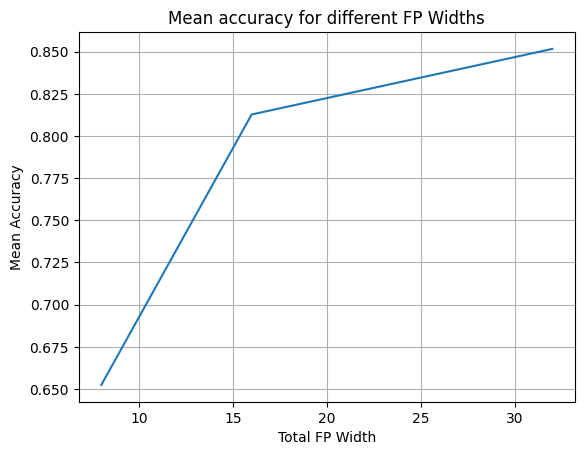

In [17]:
# Group results by params_width
grouped_2 = study_linear_2[["value", "params_width"]].groupby("params_width").mean()

# Plot the results
plt.plot(grouped_2.index, grouped_2.value)
plt.xlabel("Total FP Width")
plt.ylabel("Mean Accuracy")
plt.grid()
plt.title("Mean accuracy for different FP Widths")

plt.show()

In [24]:
# Find the best value
best_width = study_linear_2.value.idxmax()
print("Best config : ")
study_linear_2.loc[best_width][
    [
        "value",
        "params_exponent_bias",
        "params_exponent_width",
        "params_frac_width",
        "params_width",
    ]
].to_frame()

Best config : 


,16
value,0.86468
params_exponent_bias,2
params_exponent_width,4
params_frac_width,4.0
params_width,16
